In [1]:
from Vis_MDOutput import *
import mdtraj as md
import numpy as np
from openmm.unit import *
from MDAnalysis_utils import *

In [5]:
## modify input
###########################
## give the input file 
from Input_MDRun_CaCl import * 

Directory        = "/home/schaefej51/Documents/2_Projects/202207_UnbindingRatesCaSystems/OpenMM/CaDimers/"
System           = "CaCl/"
WorkingDirectory = Directory + System + Parameter 
LOGDirectory     = WorkingDirectory + 'UNBIASED/PlumedLOG.txt'
MD_input         = WorkingDirectory+"input/" 
MD_output        = WorkingDirectory+"UNBIASED/" 
AYS_output       = WorkingDirectory + 'analysis/UNBIASED/'
#name             = 'distance'
name             = 'COLVAR_d'
#name             = 'COLVAR_B_SO4_None'
#name             = 'dist_NA1:NA2'

NumberRuns       = 18
NumberAtom_1_s   = 0
NumberAtom_2_s   = 1

esc_limit        = True
esc_limit_p      =  0.35     # 0.47
esc_limit_n      =  0.35     # 0.35
esc_limit_m      =  0.35    # 0.4
esc_condition    = esc_limit_p

makeDistances   = True
saveDistances   = True
loadDistances   = False
PlumedDistances = True

In [3]:
args_path     = { 'Directory'    : Directory,
                  'System'       : System,
                  'Parameter'    : Parameter,
                  'LOGDirectory' : LOGDirectory,
                  'MD_output'    : MD_output,
                  'AYS_output'   : AYS_output
                }
args_filename = { 'NumberAtom_1' : NumberAtom_1, 
                  'NumberAtom_2' : NumberAtom_2, 
                  'old_naming'   : name
                }
args_escLimit = { 'esc_limit_p'  : esc_limit_p,
                  'esc_limit_n'  : esc_limit_n,
                  'esc_limit_m'  : esc_limit_m,
                  'esc_limit'    : esc_limit
                }

In [ ]:
## A T T E N T I O N : you can not use sanity check of input files with Plumed distances so far!
AYSLOG_checkInput(args_filename, 
                   NumberRuns,
                   NumberAtom_1_IPF=NumberAtom_1_s, 
                   NumberAtom_2_IPF=NumberAtom_2_s, 
                   nstxout=nstxout, 
                   dt=dt, 
                   T=T, 
                   cutoff=cutoff, 
                   **args_path)


In [6]:
if makeDistances:
    if PlumedDistances:
        Distances, Simulationtimes = makeDataContainer_distances(NumberRuns,MD_output,NumberAtom_1, 
                                                                 NumberAtom_2, name)
    else:
        Distances, Simulationtimes = makeDataContainer_distances(NumberRuns,MD_output,**args_filename)
        if NumberRuns != len(Simulationtimes):
            print('Proof!\n Number of runs is not identical to the length of the Distance list.')
        if np.unique(np.array(Simulationtimes)).size > 1:
            Runtimes = []
            for i, runtime_i in enumerate(Simulationtimes):
                if runtime_i != nsteps:
                    print(f'Proof!\n In run {i} different number simulation steps\n than in the input file ({nsteps}) are detected.')
        else:
            if Simulationtimes[0] != nsteps/10:
                print(f'Proof!\n A different number simulation steps ({Simulationtimes[0]}) \n than in the input file ({nsteps}) are detected.')

if saveDistances:
    if PlumedDistances:
        np.save(AYS_output + 'PlumedDistances', Distances)
    else:    
        np.save(AYS_output + 'Distances', Distances)
if loadDistances:
    if PlumedDistances:
        Distances = np.load(AYS_output + 'PlumedDistances.npy',allow_pickle=True)
    else:
        Distances = np.load(AYS_output + 'Distances.npy',allow_pickle=True)
    
    
## A T T E N T I O N : If you want to use this module with distances generated via Plumed 
##                     you have to create a Distance container first!



In [ ]:
def _check_ESCtraj(distances, esc_condition):
    for nstep, distance in enumerate(distances):
        if distance < esc_condition:
            esc_timestep = False
            continue
            
        else:
            esc_timestep = nstep+1
            break
    return esc_timestep

figuresize   = (12, 8)
fig, ax = plt.subplots(figsize=figuresize)

esc_timestep_max=0
for data in np.arange(len(Distances)):
    esc_timestep = _check_ESCtraj(Distances[data], esc_condition)
    if esc_timestep > esc_timestep_max:
        esc_timestep_max = esc_timestep
    y = Distances[data][:(esc_timestep)+2000]
    x = np.arange(len(y))
    ax.plot(x,y,ls=':',lw=0.2,color='C'+str(data))
    
    y = Distances[data][:(esc_timestep)]
    x = np.arange(len(y))
    ax.plot(x,y,color='C'+str(data),label=str(data))
    
        
    #plt.ylim(0.36,0.38)
y = Distances[0]
x = np.arange(len(y))
#plt.plot(x,y)
plt.hlines(y=esc_condition, xmin=0, xmax=esc_timestep_max, color='C0')
plt.hlines(y=esc_limit_m, xmin=0, xmax=esc_timestep_max, color='C0')
#plt.vlines(x=100, ymin=0.25, ymax=0.4, color='green', lw=2.5)
#plt.vlines(x=1000, ymin=0.25, ymax=0.4, color='green', lw=2.5)

xLabel       = r'Integration Step'
xLabelSize   = 35
xLabelPad    = 20
yLabel       = r'Distance in nm'
yLabelSize   = 35
yLabelPad    = 2
ticksSize    = 25
ticksPad     = 5
ax.set_xlabel(xLabel, fontsize=xLabelSize, labelpad=xLabelPad)
ax.set_ylabel(yLabel, fontsize=yLabelSize, labelpad=yLabelPad)
ax.tick_params(axis='both', labelsize=ticksSize, pad=ticksPad)
xLimits      = [0,esc_timestep_max]
ax.set_xlim(xLimits)
#plt.legend()

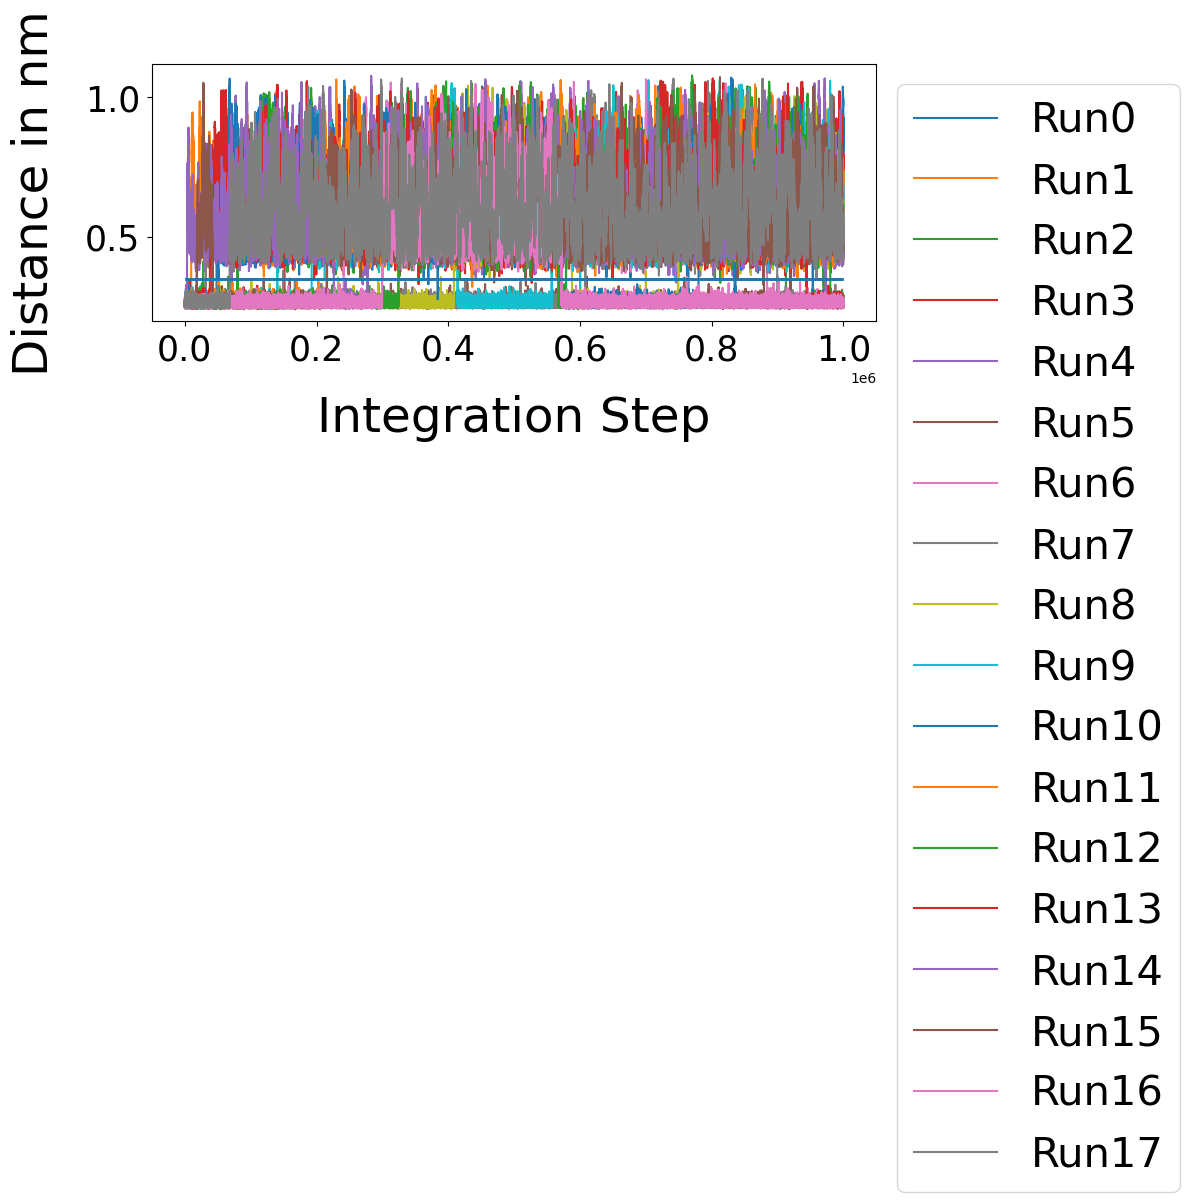

In [7]:
## UNTIL HERE TO CHECK IF args_escLimit is given correct
Mtp_DisNs(Distances, NumberRuns, **args_escLimit)
              

In [ ]:
plt.plot

In [ ]:
AYSLOG_escLimit(AYS_output, args_filename, args_escLimit)

In [8]:
esc_times = get_esc_times(Distances, NumberRuns, esc_condition, dt, nstxout)

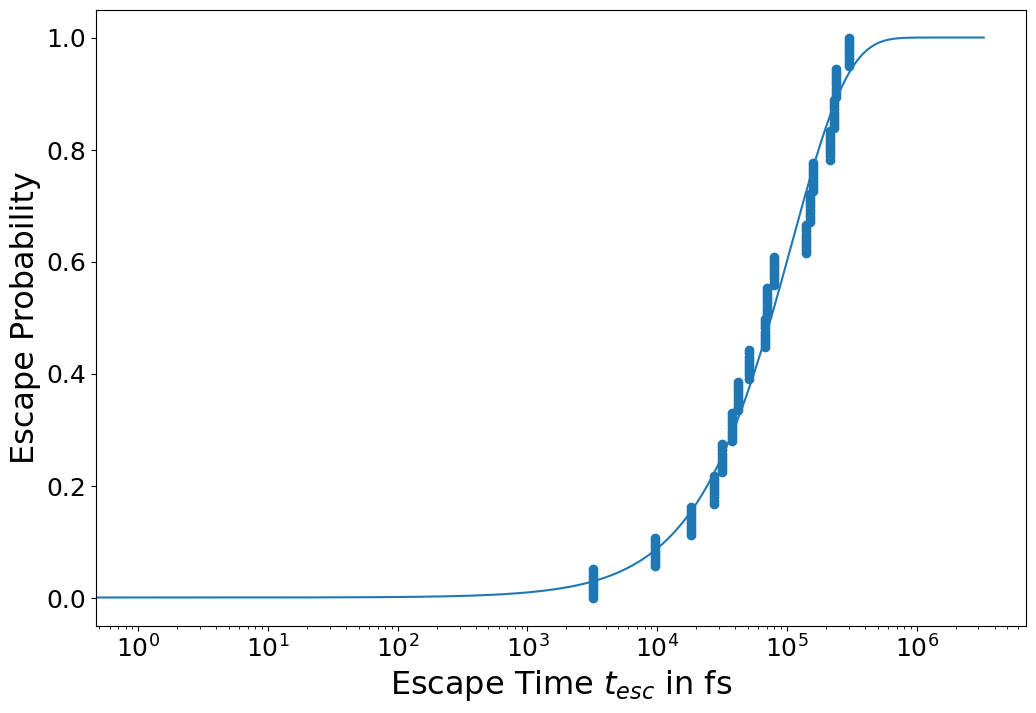

In [9]:
check_poisson(esc_times, plot=True)

In [ ]:
AYSLOG_checkSimulationQuality(Distances, NumberRuns, esc_condition,dt, 
                             nstxout, AYS_output, inline=True)

In [10]:
density, bin_array = get_density_Distances(Distances, cutoff._value, bins=60, density=False)
#plt.plot(bin_array,density)

args_potEnergy = { 'T'       : T._value,
                   'density' : density, 
                   'unit'    : 'kJ/mol'   
                 }


In [11]:
def get_potentialEnegry(T, density, unit):
    kB  = scipy.constants.Boltzmann
    if unit=='kJ/mol':
        NA  = scipy.constants.Avogadro
        return (-T*kB*np.log(density))*(10**(-3)*NA)
    if unit=='J':
        return (-T*kB*np.log(density))

In [12]:
potEnergy_surface = get_potentialEnegry(**args_potEnergy)

Emin_s=((bin_array<esc_condition)*potEnergy_surface).min()
Emin_l=((bin_array>esc_condition)*potEnergy_surface).min()
Xmin_s=bin_array[np.where(potEnergy_surface==Emin_s)[0]]
Xmin_l=bin_array[np.where(potEnergy_surface==Emin_l)[0]]
min_s = (Xmin_s[0], Emin_s)
min_l = (Xmin_l[0], Emin_l)

[0.26068487] [0.48441687]


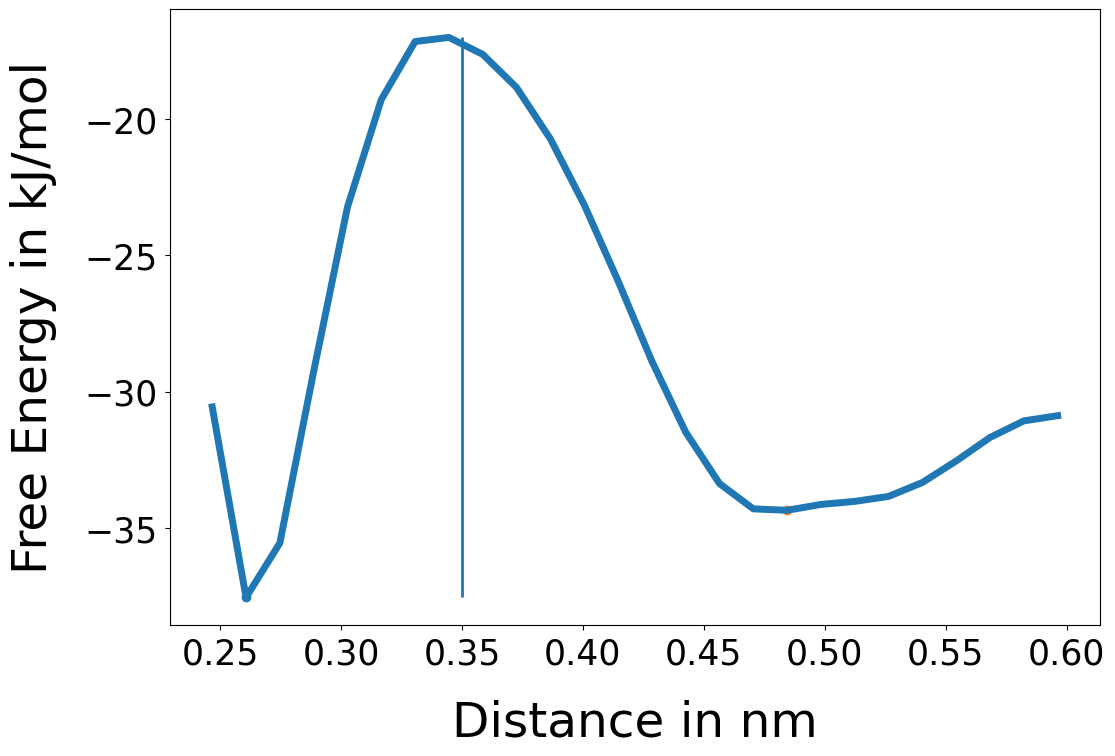

In [13]:
List_binArray= [bin_array]
#potEnergy_surface-=potEnergy_surface.max()
List_potEnergySurface= [potEnergy_surface]
Mtp_FreeEDis(List_binArray, List_potEnergySurface, esc_condition,min_s,min_l)
print(Xmin_s, Xmin_l)

In [14]:
# barrier 
lower   = ((esc_condition-0.1*esc_condition)<bin_array)
upper   = (bin_array<(esc_condition+0.1*esc_condition))
barrier = (lower*upper*potEnergy_surface)
Emax=barrier[np.where(barrier!=-0.0)].max()

Ebarrier = Emax - Emin_s
Ebarrier

20.54995182250955

In [15]:
FreeEnergy = (bin_array,potEnergy_surface)
if PlumedDistances:
    np.savetxt(AYS_output + 'unbiasedFreeEnergy.dat', FreeEnergy)
else:
    np.save(AYS_output + 'FreeEnergy', FreeEnergy)

In [ ]:

import pandas as pd

# import COLVAR file as pandas dataset
# set the right path to the COLVAR file
data = pd.read_csv(AYS_output+"COLVAR_dist", sep=" ")

In [ ]:
# import python modules
import openmmplumed
import matplotlib.pyplot as plt



 
# plot time serie of gyration radius (r) and distance (d)
plt.plot(data.FIELDS,data.time, label="distance")
# x-y axis labels
plt.xlabel("MD frame")
plt.ylabel("r/d [nm]")
plt.legend()
 